# Predicting house prices

This notebook is a mix of a data exploration together with a hyperparameter search to train the model get to deploy

## 1) Libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import pickle

## 2) Data loading

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## 3) First glimpse of the data set

Getting an idea of the data set information

In [3]:
train.describe()

,net_usable_area,net_area,n_rooms,n_bathroom,latitude,longitude,price
count,16212.000000,1.621200e+04,16212.000000,16212.000000,16212.000000,16212.000000,16212.000000
mean,249.409339,6.186665e+02,3.590550,3.024241,-33.403506,-70.560875,16180.463607
std,2774.766864,1.169530e+04,1.449744,1.331352,0.036072,0.036081,12774.658484
min,0.000000,0.000000e+00,0.000000,0.000000,-33.524410,-70.643660,0.000000
25%,98.000000,1.100000e+02,3.000000,2.000000,-33.431350,-70.589872,8079.750000
50%,140.000000,1.984750e+02,3.000000,3.000000,-33.406670,-70.564120,12500.000000
75%,242.000000,4.750000e+02,4.000000,4.000000,-33.378327,-70.531537,20000.000000
max,180116.000000,1.430000e+06,55.000000,55.000000,-33.305250,-70.431890,215000.000000


In [4]:
test.describe()

,net_usable_area,net_area,n_rooms,n_bathroom,latitude,longitude,price
count,6949.000000,6949.000000,6949.000000,6949.000000,6949.000000,6949.000000,6949.000000
mean,252.181448,576.459468,3.571521,3.034825,-33.403117,-70.560321,16046.993524
std,3442.457112,7178.302387,1.316192,1.282133,0.036187,0.035763,12196.083490
min,0.000000,0.000000,0.000000,0.000000,-33.538300,-70.646980,14.000000
25%,100.000000,114.000000,3.000000,2.000000,-33.430200,-70.589660,8300.000000
50%,140.000000,200.000000,3.000000,3.000000,-33.406600,-70.563050,12390.000000
75%,240.000000,450.000000,4.000000,4.000000,-33.377670,-70.530650,20000.000000
max,250000.000000,570000.000000,16.000000,30.000000,-33.309450,-70.462100,214000.000000


Taking a look at catalorical variables

In [5]:
train['type'].unique(), test['type'].unique()

(array(['departamento', 'casa'], dtype=object),
 array(['casa', 'departamento'], dtype=object))

In [6]:
train['sector'].unique(), test['sector'].unique()

(array(['vitacura', 'la reina', 'las condes', 'lo barnechea',
        'providencia', 'nunoa'], dtype=object),
 array(['vitacura', 'las condes', 'la reina', 'providencia',
        'lo barnechea', 'nunoa'], dtype=object))

## 4) Data pre-process

In [7]:
def data_prep(df):
    '''
    This function is responsible to:
        1) Sample the data set
        2) Remove nan values
        3) Tranform categorical into numerical information 
        4) Transform skewed distributions
    '''

    #1) Sampling the data set
    df = df.sample(frac = 1)

    #2) Removing nan values
    df = df.dropna()

    #3) Transforming categorical to numerical information
    LE = LabelEncoder()

    df['type'] = LE.fit_transform(df['type'])
    df['sector'] = LE.fit_transform(df['sector'])

    #4) Tranforming skewed distributions
    df['net_usable_area'] = np.log10(df['net_usable_area'] + 10**(-3))
    df['net_area'] = np.log10(df['net_area'] + 10**(-3))
    df['price'] = np.log10(df['price'] + 10**(-3))

    return df


In [8]:
train = data_prep(train)
test = data_prep(test)
train.shape, test.shape

((16212, 9), (6949, 9))

Taking a look at the data after pre-processing it

array([[<Axes: title={'center': 'type'}>,
        <Axes: title={'center': 'sector'}>,
        <Axes: title={'center': 'net_usable_area'}>],
       [<Axes: title={'center': 'net_area'}>,
        <Axes: title={'center': 'n_rooms'}>,
        <Axes: title={'center': 'n_bathroom'}>],
       [<Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'price'}>]], dtype=object)

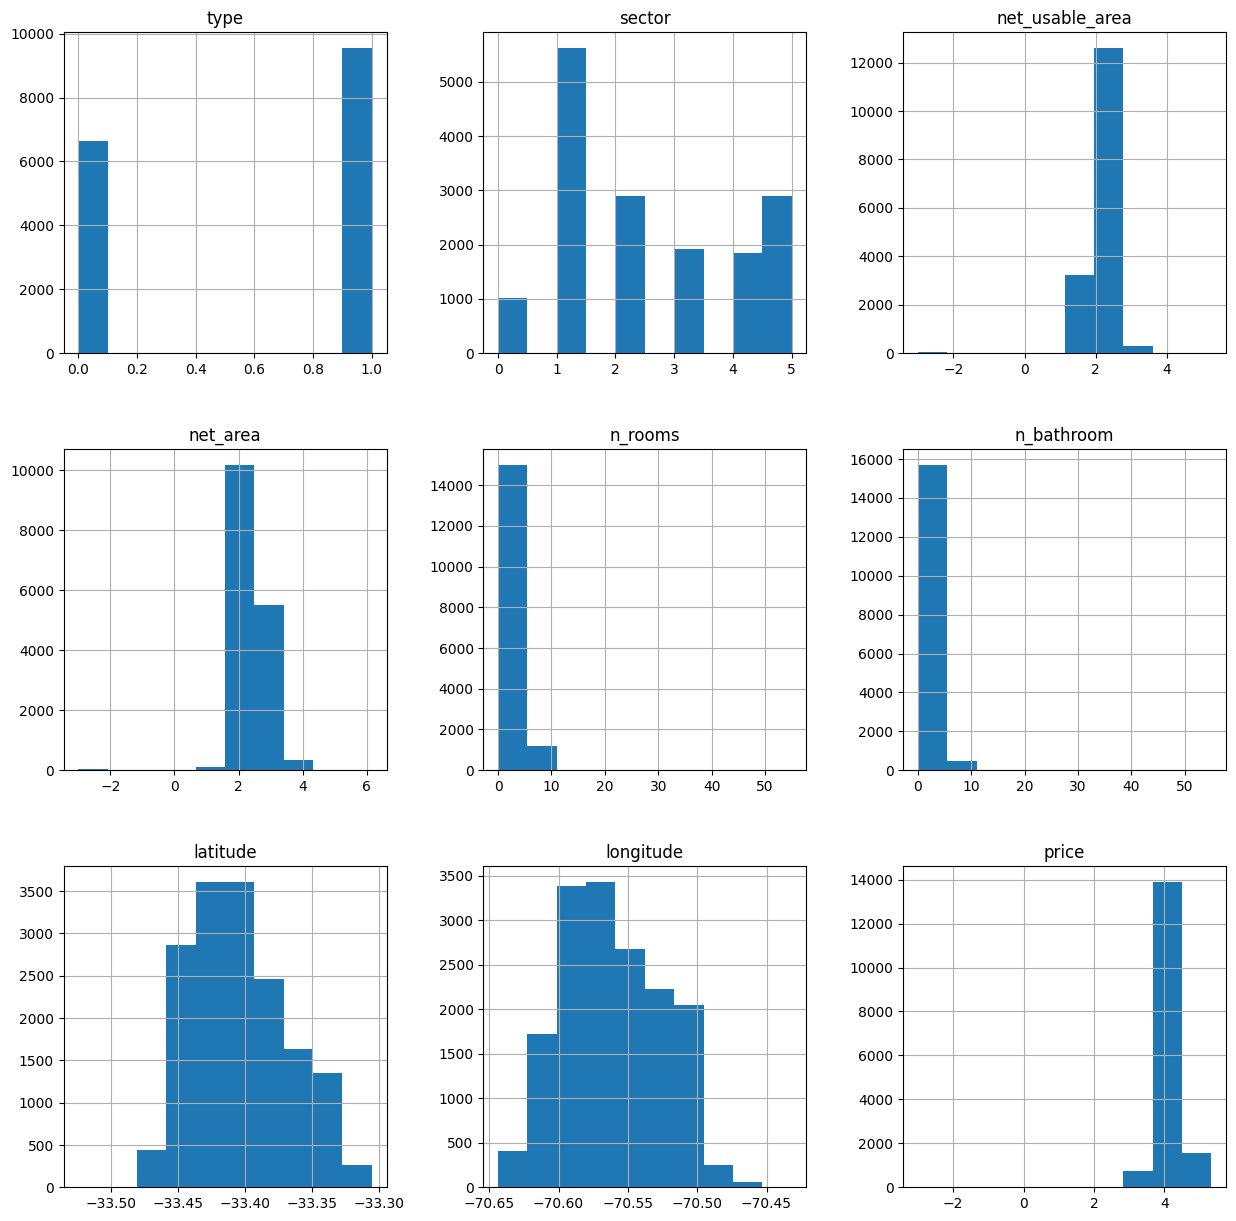

In [9]:
train.hist(bins = 10, figsize = (15, 15))

array([[<Axes: title={'center': 'type'}>,
        <Axes: title={'center': 'sector'}>,
        <Axes: title={'center': 'net_usable_area'}>],
       [<Axes: title={'center': 'net_area'}>,
        <Axes: title={'center': 'n_rooms'}>,
        <Axes: title={'center': 'n_bathroom'}>],
       [<Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'price'}>]], dtype=object)

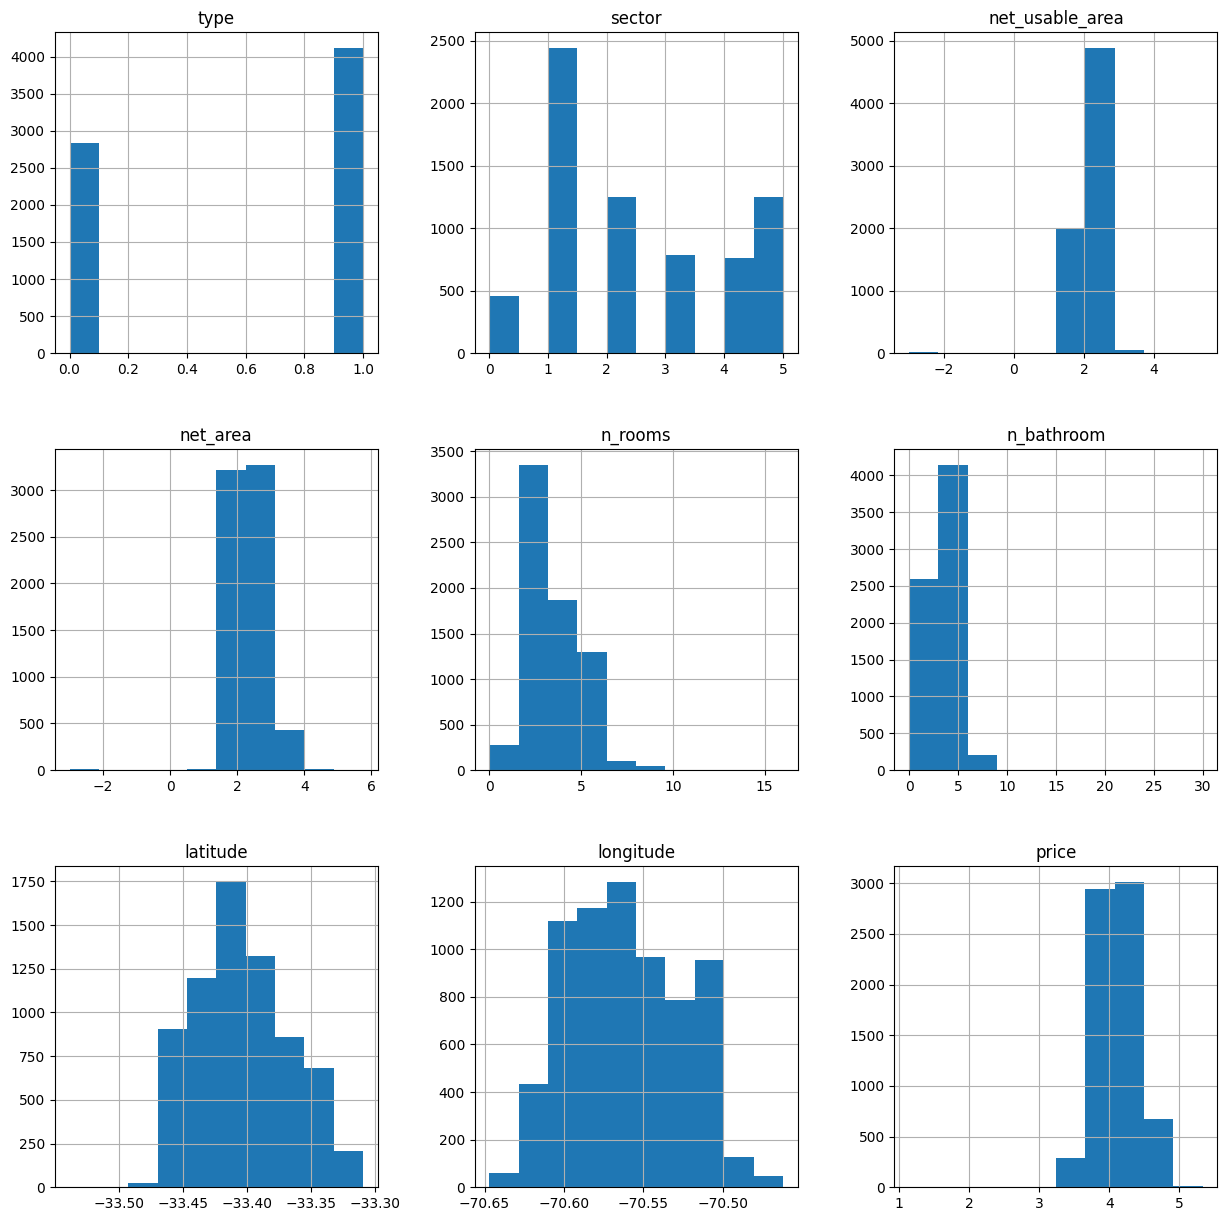

In [10]:
test.hist(bins = 10, figsize = (15, 15))

## 5) Measuring data correlation

In [11]:
def correlation_heatmap(df):
    '''
    This function measures the correlation between the variables
    '''
    correlations = df.corr(method = 'pearson')

    fig, ax = plt.subplots(figsize = (10,10))
    sns.heatmap(correlations, vmax = 1.0, center = 0, fmt = '.2f',
                square = True, linewidths = .5, annot = True, cbar_kws = {"shrink": .82})
    plt.title('Pearson correlation Heatmap')
    plt.show()
    
    return correlations

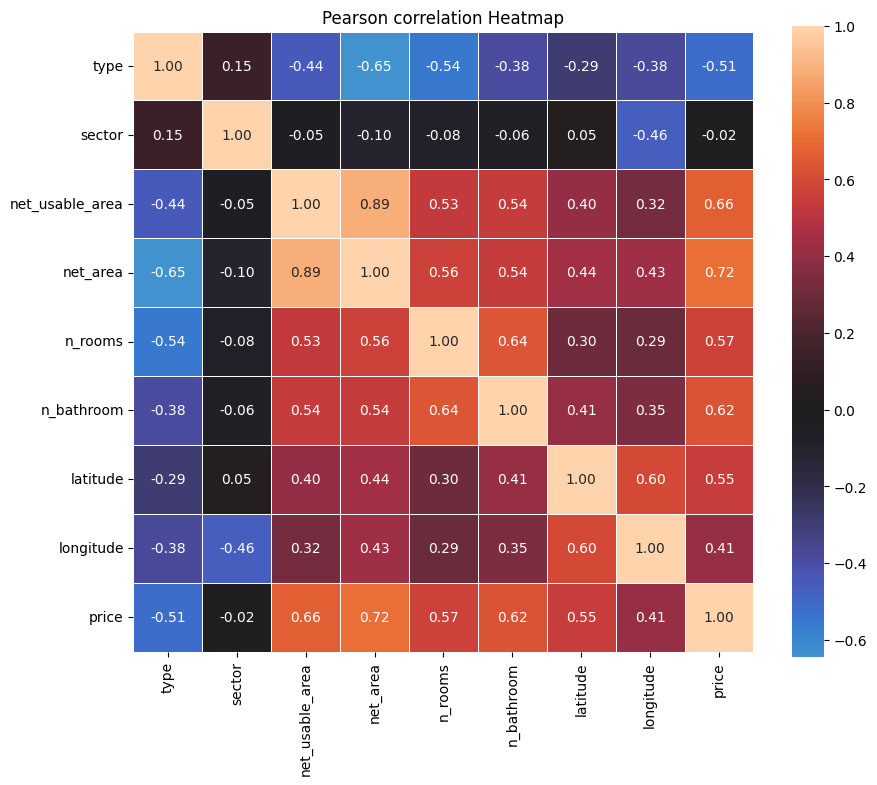

,type,sector,net_usable_area,net_area,n_rooms,n_bathroom,latitude,longitude,price
type,1.000000,0.148203,-0.441065,-0.645614,-0.543487,-0.384912,-0.291043,-0.378523,-0.510496
sector,0.148203,1.000000,-0.045011,-0.100820,-0.082987,-0.061961,0.045586,-0.461351,-0.017839
net_usable_area,-0.441065,-0.045011,1.000000,0.888985,0.533774,0.539934,0.395837,0.320898,0.662804
net_area,-0.645614,-0.100820,0.888985,1.000000,0.563727,0.543025,0.442593,0.429620,0.715742
n_rooms,-0.543487,-0.082987,0.533774,0.563727,1.000000,0.636368,0.301094,0.293868,0.566799
n_bathroom,-0.384912,-0.061961,0.539934,0.543025,0.636368,1.000000,0.413842,0.348156,0.623408
latitude,-0.291043,0.045586,0.395837,0.442593,0.301094,0.413842,1.000000,0.595562,0.546459
longitude,-0.378523,-0.461351,0.320898,0.429620,0.293868,0.348156,0.595562,1.000000,0.413152
price,-0.510496,-0.017839,0.662804,0.715742,0.566799,0.623408,0.546459,0.413152,1.000000


In [12]:
correlation_heatmap(train)

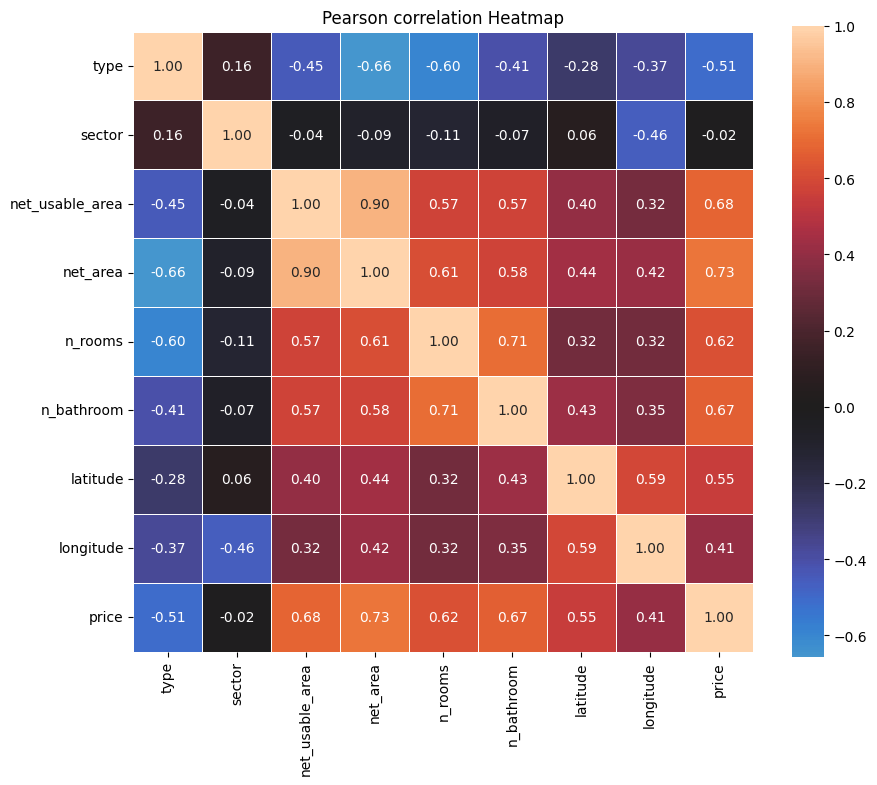

,type,sector,net_usable_area,net_area,n_rooms,n_bathroom,latitude,longitude,price
type,1.000000,0.158003,-0.449748,-0.657306,-0.597214,-0.408420,-0.278136,-0.371238,-0.511971
sector,0.158003,1.000000,-0.037847,-0.092162,-0.113552,-0.073832,0.061281,-0.458241,-0.015053
net_usable_area,-0.449748,-0.037847,1.000000,0.899020,0.569976,0.571632,0.399469,0.322577,0.678489
net_area,-0.657306,-0.092162,0.899020,1.000000,0.613400,0.575727,0.442244,0.422302,0.734442
n_rooms,-0.597214,-0.113552,0.569976,0.613400,1.000000,0.707054,0.317387,0.317174,0.622642
n_bathroom,-0.408420,-0.073832,0.571632,0.575727,0.707054,1.000000,0.429723,0.351626,0.667565
latitude,-0.278136,0.061281,0.399469,0.442244,0.317387,0.429723,1.000000,0.587158,0.547712
longitude,-0.371238,-0.458241,0.322577,0.422302,0.317174,0.351626,0.587158,1.000000,0.410109
price,-0.511971,-0.015053,0.678489,0.734442,0.622642,0.667565,0.547712,0.410109,1.000000


In [13]:
correlation_heatmap(test)

## 6) Getting data ready to machine learning

In [14]:
def selecting_data(df):
    '''
    This function split the corresponding data set into:
        X: input variables
        y: output variables
    '''

    X = np.array([df['type'], df['sector'], df['net_usable_area'], 
                  df['net_area'], df['n_rooms'], df['n_bathroom'],
                  df['latitude'], df['longitude'] 
                  ]).T
    
    y = np.array([df['price']]).T

    return X, y

In [15]:
def splitting_data(X, y, p_train):
    '''
    This function split the train data set into train and validation
    '''

    p_val = 1. - p_train

    X_val = X[:int(p_val*X.shape[0])]
    y_val = y[:int(p_val*y.shape[0])]

    X_train = X[int(p_val*X.shape[0]):]
    y_train = y[int(p_val*y.shape[0]):]

    return X_train, y_train, X_val, y_val

In [16]:
X_train, y_train = selecting_data(train)
X_train, y_train, X_val, y_val = splitting_data(X_train, y_train, 0.8)
X_test, y_test = selecting_data(test)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((12970, 8), (3242, 8), (6949, 8), (12970, 1), (3242, 1), (6949, 1))

## 7) Machine Learning grid search

In this part I will define the grid search for `GradientBoostingRegressor`

In [17]:
def grid_search_GradientBoostingRegressor(X_val, y_val):
    '''
    This function defines a grid search for GradientBoostingRegressor
    using the validation set
    '''

    #Instatiating the model
    model = GradientBoostingRegressor()

    #Defining the grid
    grid = dict()
    grid['n_estimators'] = [100, 300]
    grid['learning_rate'] = [0.001, 0.01]
    grid['max_depth'] = [3, 5]
    grid['loss'] = ["absolute_error"]

    #Instatiating the grid search
    grid_search = GridSearchCV(estimator = model, param_grid = grid)

    #Performing the grid search
    grid_result = grid_search.fit(X_val, y_val[:, 0])

    #Summarizing the best score hyperparameter
    hyperparams = grid_result.best_params_
    
    return hyperparams

In [18]:
hyperparams = grid_search_GradientBoostingRegressor(X_val, y_val)
hyperparams

{'learning_rate': 0.01,
 'loss': 'absolute_error',
 'max_depth': 5,
 'n_estimators': 300}

## 8) Training and saving the GradientBoostingRegressor with the best set of hyperparameters found

In [21]:
def train_and_save(hyperparams, X_train, y_train):
    '''
    This function trains and save (as pickle) the GradientBoostingRegressor 
    using the best set of hyperparameters found with the GridSearch
    '''

    #Instatiating the model
    model = GradientBoostingRegressor(**hyperparams)

    #Fitting the model
    model.fit(X_train, y_train[:, 0])

    #Saving the model to pickle file
    pickle.dump(model, open("model/pima.pickle.dat", "wb"))

    return print('The model was trained and saved!')

In [22]:
train_and_save(hyperparams, X_train, y_train)

The model was trained and saved!


## Loading and evaluating

In [27]:
def load_and_evaluate(X, y):
    '''
    This function load the trained model and provides some evaluation metrics
    '''

    #Load model from file
    loaded_model = pickle.load(open("model/pima.pickle.dat", "rb"))

    #Predicting the house prices for the selected set
    pred = loaded_model.predict(X)

    #Evaluating the model
    RMSE = np.sqrt(mean_squared_error(pred, y))
    MSE = mean_squared_error(pred, y)
    MAPE = mean_absolute_percentage_error(pred, y)

    #printing metrics
    print("RMSE: ", np.sqrt(mean_squared_error(pred, y)))
    print("MAPE: ", mean_absolute_percentage_error(pred, y))
    print("MAE : ", mean_absolute_error(pred, y))

In [28]:
load_and_evaluate(X_test, y_test)

RMSE:  0.12117601648515183
MAPE:  0.015789610622256228
MAE :  0.0652744326965716
